In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

sns.set_style('white')
sns.set_context('poster')


# Solutions: Ensemble Modeling
For some introduction, please see notebook 1. This notebook assumes some acquintance with the scikit-learn API. Much of the material here is adapted from [Python Data Science Handbook](https://github.com/jakevdp/PythonDataScienceHandbook) by Jake VanderPlas and a [workshop at SciPY 2016](https://github.com/amueller/scipy-2016-sklearn) by Sebastian Raschka and Andreas Mueller.

A lot of models have some shortcomings, not a single model is ever the perfect choice. An early example of ensemble modeling is the addition of many decision trees into one so-called random forest. In the random realizations, both random subsets of observations, as well as random subsets of features are used. The name is obvious, it randomly resamples the trees to construct a whole forest of trees that together will give you both a well-performing, as well as stable model.

Let's create a tree again, on the following data set:



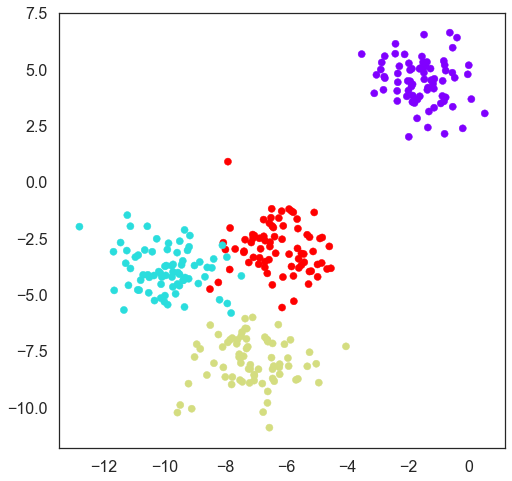

In [2]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=1, cluster_std=1.0)
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=2, ).fit(X, y)

Here is a function to visually plot the resulting decision. Please take a minute to digest what happens. We will use it throughout this notebook.

In [3]:
def visualize_classifier(model, X, y, cmap='rainbow'):
    fig, ax = plt.subplots(figsize=(8,8))
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)
    print("Model score:", model.score(X, y))

This is what this function results in. Examine it for this case. Vary the max_depth and see what happens to the decision function. See if you can determine the order of the "decisions" (horizontal or vertical cuts through the remaing data) from the images.

Model score: 0.75


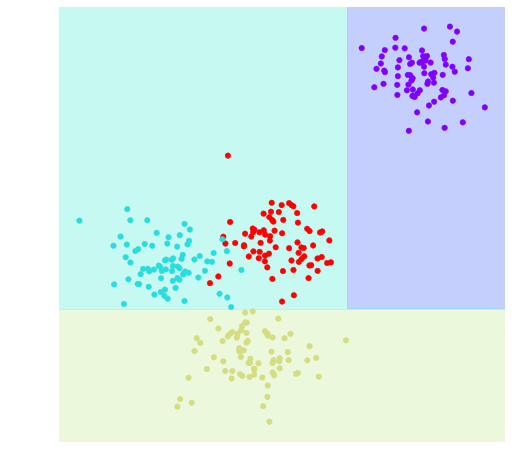

In [4]:
visualize_classifier(tree, X, y)

Now take random subsamples of the data and inspect the decision function for various such samples, with a low maximum depth tree. What is going on?

Now, train a random forest. Experiment with hyperparameters and inspect visually. Is it still easy to explain to the resulting decision function? Is this stable? Investigate in some detail!

Now let's create a data set that should challenge a whole bunch of models!

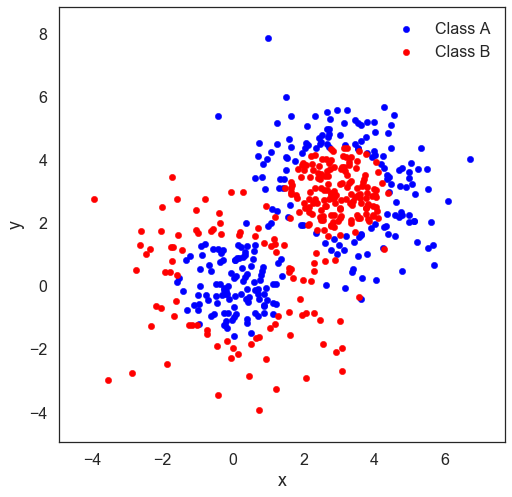

In [9]:
from sklearn.datasets import make_gaussian_quantiles
X1, y1 = make_gaussian_quantiles(cov=2., n_samples=200, n_features=2, n_classes=2, random_state=1)
X2, y2 = make_gaussian_quantiles(mean=(3, 3), cov=1.5, n_samples=300, n_features=2, n_classes=2, random_state=1)
X = np.concatenate((X1, X2))
y = np.concatenate((y1, - y2 + 1))

# And plot it!
plt.figure(figsize=(8,8))
plot_colors = "br"
class_names = "AB"
for i, n, c in zip(range(2), class_names, plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=c, s=40, cmap=plt.cm.Paired,label="Class %s" % n)
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend(loc='upper right')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Just because we are so familiar with them now, please run a decision tree with very shallow maximum depth. It will do as bad as you think!

What kind of classifier that you have seen before do you expect to perform pretty well? Try!

## Let's bagg it!

A random forest is a bagging (or: averaging) method. The idea is to combine, or average, several base estimators, to find a more robust model, by reducing the variance of the ensemble, over any of its ingredients.

Let's not exhaust ourselves trying it by hand first. Three things to try:
- A nearest neighbor estimator with 2 neighbors is easy to run. Do it. Then bagg it with all the default settings. This should be pretty close to zero extra effort. How much do you gain for free?
- Random forests can be run by themselves, or as a BaggingClassifier of a bunch of decision trees. Can you get both methods to result in the same score or even visual appearance? (Don't try too hard... but think about the issue!)
- Support Vector Machines can do very well on this subject by themselves, if you happen to pick the right kernel. The linear kernel is not one of them. Try it nonetheless and see if bagging helps (even at hundreds of estimators). What about the rbf kernel (default). Does it do well? Does bagging help?

## Boosting

Boosting is in some way the opposite of bagging, as it tries to reduce the *bias* rather than the variance.

The best ingredients for boosting models are weak models. A good example of a weak model is a shallow decision tree. 
- Try to classify the data set here with a decision tree of max_depth=1, and compare the mdoel itself, to a bagged version and finally a boosted version. Then try it with a deeper tree (max_depth=4).
- As we saw, SVC with kernel='rbf' is a good model. Does boosting make it even better?

## Stacking

A final  way of combining models s to throw together fundamentally different learners. In the examples above, several tries of SVMs were combined. You could imagine you want to combine a Support Vector Machine with a Random Forest and a Logistic Regression. Because you can.

That sort of methods would be called stacking, because you build a whole stack of estimators and then you somehow combine the results of these. The popular choice is to combine the results of learners using a logistic regression. Here is an outline of the procedure, up to you to code it:
- Come up with a few models and train and evaluate them one by one.
- You wil need to record the predictions for the data, and may want to look at the probabilities.
- Put the predictions in one container, e.g. a DataFrame
- Define the stacked classifier, e.g. a logistic regression
- Train and evaluate it with teh earlier predictions as input, predicting the same classes.

Experiment with some combinations. Does the stack always perform better than any of its constituents?

## Bonus: can you use the probabilities of the individual classifiers?